## Loading the dataset
After downloading the dataset from http://ufldl.stanford.edu/housenumbers/ in the second variant (32x32 images with a single number centered)

In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 42kB/s 
     |████████████████████████████████| 3.8MB 29.7MB/s 
     |████████████████████████████████| 450kB 45.1MB/s 
     |████████████████████████████████| 81kB 13.1MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.1.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorboard 2.1.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np, random, os
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import json

#Read the datasets into memory
from scipy.io import loadmat

train = loadmat('drive/My Drive/Colab Notebooks/train_32x32.mat')
test = loadmat('drive/My Drive/Colab Notebooks/test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((32, 32, 3, 73257), (73257, 1), (32, 32, 3, 26032), (26032, 1))

In [3]:
#reshape the arrays to have the sample number as the first index

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_img.shape, train_lbs.shape, test_img.shape, test_lbs.shape

((73257, 32, 32, 3), (73257, 1), (26032, 32, 32, 3), (26032, 1))

In [0]:
#label for 0 is 10, change to 0 the label for 0

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

### Convert from rgb to grayscale

In [0]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

In [0]:
train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

## Extract a random validation set from the training set
In this case the size of the validation set is 10% of the training set.  
It is randomly extracted because the order of the images in the training set it's not random: consecutive images are part of the same original image with a complete house number.

In [7]:
#Divide training and validation
#validation set size is 10% of training set
validation_percentage = 0.1
validation_size = int(validation_percentage * train_img.shape[0])
#select the validation set as a random sample from the training set
random.seed(0) #chosen seed so the set is always the same
sample = random.sample(range(train_img.shape[0]), validation_size)
validation_img = train_img[sample,:,:,:]
train_img = np.delete(train_img, sample, 0)
validation_lbs = train_lbs[sample,:]
train_lbs = np.delete(train_lbs, sample, 0)

train_img.shape, validation_img.shape, train_lbs.shape, validation_lbs.shape

((65932, 32, 32, 1), (7325, 32, 32, 1), (65932, 1), (7325, 1))

## Visualize the images

In [0]:
#Function to visualize image with their respective labels
def plot_img_grayscale(images, labels, rows=2, cols=8):
    plt.figure(figsize=(cols*2,rows*2))
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,0], cmap='gray',vmin=0, vmax=255)
        # The labels happen to be arrays, 
        # which is why you need the extra index
        plt.xlabel(labels[i][0])
    plt.show()

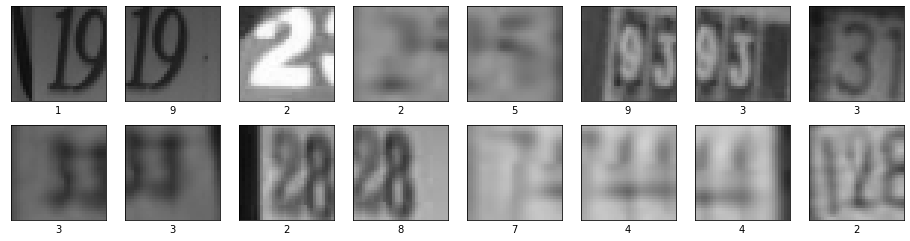

In [10]:
plot_img_grayscale(train_img, train_lbs)

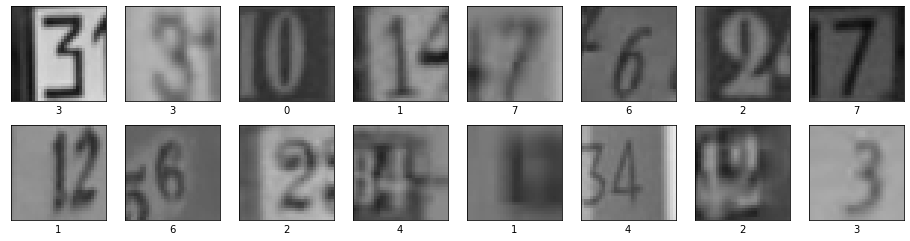

In [11]:
#Check if the validation set is divided correctely and print the data
plot_img_grayscale(validation_img, validation_lbs)

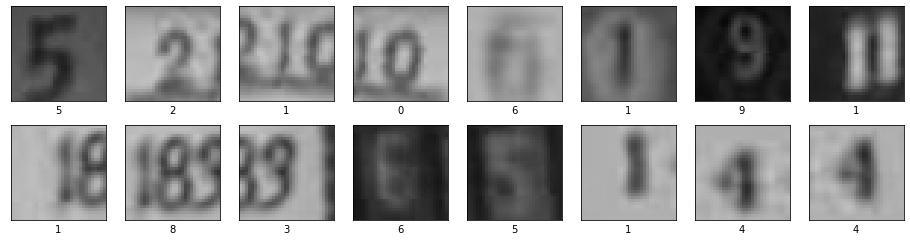

In [12]:
plot_img_grayscale(test_img, test_lbs)

## Data preprocessing

Two techniques are used in this order on the training set:

- **zero centering**: this is achieved by subctracting the mean of each colour channel (in this case just one beacuse the images are grayscaled) across said colour channel.
- **normalization**: divide each colour channel by its standard deviation (calculated after zero centering).

The same techniques are applied also on the validation set and test set but using the same parameters (mean and standard deviation) obtained from the training set.

In [0]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for validation and test set
validation_img = validation_img - train_mean
validation_img = validation_img / train_std
test_img = test_img - train_mean
test_img = test_img / train_std

## Hyper-parameters Optimization

In [0]:
##hyper parameters network structure, batch size, learning rate, drop-out

#do the train
#see what hyperparameters do better on val set
#redo the trainign with the best parameters on val set + train set
#evaluate on training set

#adapt network architecture:
#try max pool instead of stride or vice versa
#try global avarage pooling vs fully connected

In [0]:
#train on 6 epochs
EPOCH_NUM = 10

#default batch size
BATCH_SIZE = 128

#set to True to save checkpoints of the training
SAVE = False

#allows to save the weights for a model in a directory called dir_name
def checkpoint(dir_name):
    #make dir otherwise the checkpoint creation throws Exception
    os.makedirs(dir_name, exist_ok=True)
    return tf.keras.callbacks.ModelCheckpoint(filepath=dir_name+'/cp-{epoch:02d}.hd5', verbose=0, period=3)

#create multiple learning rates
def learning_rate(i, power=-3):
    return tf.keras.callbacks.LearningRateScheduler(lambda x: 10**power * (0.8 - (0.025*i )) ** x, verbose=0)

def create_callbacks(dir_name, lr=0, power=-3):
    cb = []
    if SAVE:
        cb.append(checkpoint(dir_name))
    cb.append(learning_rate(lr, power))
    return cb

In [0]:
#define function to plot accuracy or loss
def plot_validation(history, loss=False):
    number_of_models = len(history)
    if loss:
        name, key, loc, f = 'Loss', 'loss', 'lower left', min
    else:
        name, key, loc, f = 'Accuracy', 'accuracy', 'upper left', max
    plt.figure(figsize=(8,3))
    for i in range(number_of_models):
        plt.plot(history[i].history['val_'+key], label='val_'+key+str(i))
        print('CNN {0}: Epochs={1:d}, Train {2}={3:.5f}, Validation {2}={4:.5f}'.format(
            i,len(history[i].history[key]),name,f(history[i].history[key]),f(history[i].history['val_'+key])))
    plt.title('Validation '+ name)
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend(loc='upper left')
    plt.show()

In [0]:
#funciton to get the index of the model with the best accuracy or loss
def get_best_model(history, loss=False):
    number_of_models = len(history)
    key, op = ('val_loss', min) if loss else ('val_accuracy', max)
    max_values = []
    for i in range(number_of_models):
        best_value = op([x for x in history[i].history[key]])
        max_values.append(best_value)
    return max_values.index(op(max_values))

In [0]:
#save the history from a list of trained models
def save_history(hist_list, path):
    if path != None:
        for i in range(len(hist_list)):
            #make dir otherwise file creation throws exception
            os.makedirs(path+str(i), exist_ok=True)
            json.dump(str(hist_list[i].history), open(path+str(i)+"/hist"+str(i)+".json", 'w'))
    
def load_history(path):
    return json.load(open(path, 'r'))

### Explain the basic structure on their hyper parameters
we are now going ot start hyperparameter evaluation

the basic network structure will be  
(conv2dLayer\* **N** (filterSize\* **L**) -> (maxPool or Stride))\***M** -> (FCnonlinear\***K** -> FCsoftmax) or (Global avarage pooling)

There are two typical architecture: conv layer followed by a max pooling or smaller conv layer followed by a conv layer with stride=2. Here the two are confronted giving each one roughly the same number of convolutional neurons.

### Validate the number of covolutional layers

In [0]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    if i > 0:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 0:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i > 3:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    if i == 2 or i == 5:
        model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i == 3 or i == 6:
        model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/layers/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 4s 67us/sample - loss: 0.8284 - accuracy: 0.7495 - val_loss: 0.5257 - val_accuracy: 0.8558
Epoch 2/10
65932/65932 [==============================] - 4s 60us/sample - loss: 0.4608 - accuracy: 0.8704 - val_loss: 0.4743 - val_accuracy: 0.8627
Epoch 3/10
65932/65932 [==============================] - 4s 60us/sample - loss: 0.3786 - accuracy: 0.8914 - val_loss: 0.4114 - val_accuracy: 0.8799
Epoch 4/10
65932/65932 [==============================] - 4s 61us/sample - loss: 0.3266 - accuracy: 0.9065 - val_loss: 0.3962 - val_accuracy: 0.8841
Epoch 5/10
65932/65932 [==============================] - 4s 59us/sample - loss: 0.2882 - accuracy: 0.9178 - val_loss: 0.3834 - val_accuracy: 0.8867
Epoch 6/10
65932/65932 [==============================] - 4s 59us/sample - loss: 0.2571 - accuracy: 0.9272 - val_loss: 0.3864 - val_accuracy: 0.8897
Epoch 7/10
65932/65932 [==============================] -

CNN 0: Epochs=10, Train Accuracy=0.94933, Validation Accuracy=0.89270
CNN 1: Epochs=10, Train Accuracy=0.98415, Validation Accuracy=0.91263
CNN 2: Epochs=10, Train Accuracy=0.99048, Validation Accuracy=0.91768
CNN 3: Epochs=10, Train Accuracy=0.99788, Validation Accuracy=0.92191
CNN 4: Epochs=10, Train Accuracy=0.98957, Validation Accuracy=0.91713
CNN 5: Epochs=10, Train Accuracy=0.98392, Validation Accuracy=0.92205
CNN 6: Epochs=10, Train Accuracy=0.99914, Validation Accuracy=0.91782


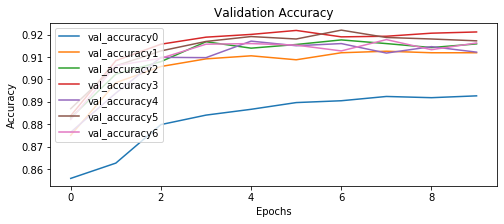

CNN 0: Epochs=10, Train Loss=0.18531, Validation Loss=0.38170
CNN 1: Epochs=10, Train Loss=0.06943, Validation Loss=0.30781
CNN 2: Epochs=10, Train Loss=0.04133, Validation Loss=0.28275
CNN 3: Epochs=10, Train Loss=0.01170, Validation Loss=0.28666
CNN 4: Epochs=10, Train Loss=0.04805, Validation Loss=0.30348
CNN 5: Epochs=10, Train Loss=0.06503, Validation Loss=0.27967
CNN 6: Epochs=10, Train Loss=0.00432, Validation Loss=0.29656


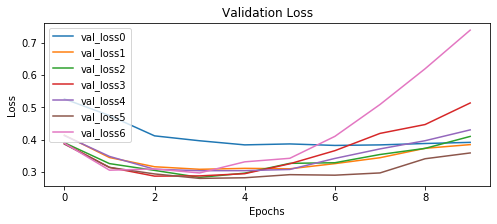

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 5 is the best one
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_63 (Conv2D)    

### Validate max-pool over stride2

In [0]:
val_models = []

models_number = 2
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if i == 0:
        model.add(layers.MaxPooling2D())
    else:
        model.add(layers.Conv2D(16, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if i ==0:
        model.add(layers.MaxPooling2D())
    else:
        model.add(layers.Conv2D(32, (3,3), strides=2, activation='relu'))
    
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/stride/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 7s 101us/sample - loss: 0.8197 - accuracy: 0.7315 - val_loss: 0.4269 - val_accuracy: 0.8663
Epoch 2/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.3436 - accuracy: 0.8970 - val_loss: 0.3441 - val_accuracy: 0.8994
Epoch 3/10
65932/65932 [==============================] - 6s 95us/sample - loss: 0.2696 - accuracy: 0.9210 - val_loss: 0.3101 - val_accuracy: 0.9104
Epoch 4/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.2250 - accuracy: 0.9336 - val_loss: 0.2931 - val_accuracy: 0.9137
Epoch 5/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.1895 - accuracy: 0.9449 - val_loss: 0.2798 - val_accuracy: 0.9193
Epoch 6/10
65932/65932 [==============================] - 6s 92us/sample - loss: 0.1587 - accuracy: 0.9548 - val_loss: 0.2877 - val_accuracy: 0.9208
Epoch 7/10
65932/65932 [==============================] 

CNN 0: Epochs=10, Train Accuracy=0.98218, Validation Accuracy=0.92082
CNN 1: Epochs=10, Train Accuracy=0.98881, Validation Accuracy=0.91986


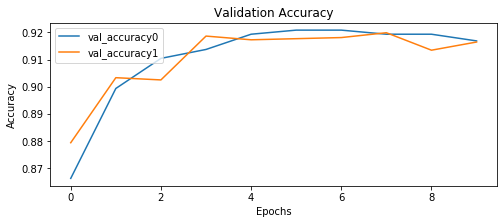

CNN 0: Epochs=10, Train Loss=0.07101, Validation Loss=0.27978
CNN 1: Epochs=10, Train Loss=0.04557, Validation Loss=0.28261


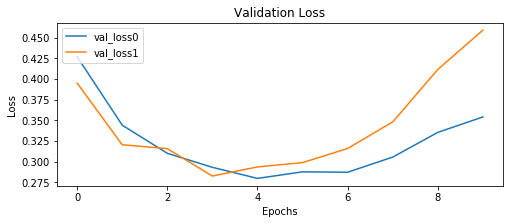

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 0 is the best one
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_93 (Conv2D)    

### Validate the number of filters per layer

In [0]:
val_models = []

models_number = 7
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(32+8*i, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(32+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(32+8*i, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(64+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64+16*i, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(48+8*i, (3,3), padding='same', activation='relu'))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/filters/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 10s 148us/sample - loss: 0.7799 - accuracy: 0.7477 - val_loss: 0.4212 - val_accuracy: 0.8777
Epoch 2/10
65932/65932 [==============================] - 9s 137us/sample - loss: 0.3074 - accuracy: 0.9089 - val_loss: 0.2906 - val_accuracy: 0.9125
Epoch 3/10
65932/65932 [==============================] - 9s 139us/sample - loss: 0.2318 - accuracy: 0.9328 - val_loss: 0.2681 - val_accuracy: 0.9218
Epoch 4/10
65932/65932 [==============================] - 9s 139us/sample - loss: 0.1868 - accuracy: 0.9460 - val_loss: 0.2650 - val_accuracy: 0.9208
Epoch 5/10
65932/65932 [==============================] - 9s 139us/sample - loss: 0.1496 - accuracy: 0.9577 - val_loss: 0.2504 - val_accuracy: 0.9259
Epoch 6/10
65932/65932 [==============================] - 9s 141us/sample - loss: 0.1137 - accuracy: 0.9680 - val_loss: 0.2675 - val_accuracy: 0.9282
Epoch 7/10
65932/65932 [==========================

CNN 0: Epochs=10, Train Accuracy=0.99422, Validation Accuracy=0.92819
CNN 1: Epochs=10, Train Accuracy=0.99867, Validation Accuracy=0.93201
CNN 2: Epochs=10, Train Accuracy=0.99712, Validation Accuracy=0.92669
CNN 3: Epochs=10, Train Accuracy=0.99915, Validation Accuracy=0.93379
CNN 4: Epochs=10, Train Accuracy=0.99885, Validation Accuracy=0.93092
CNN 5: Epochs=10, Train Accuracy=0.99873, Validation Accuracy=0.93324
CNN 6: Epochs=10, Train Accuracy=0.99507, Validation Accuracy=0.93051


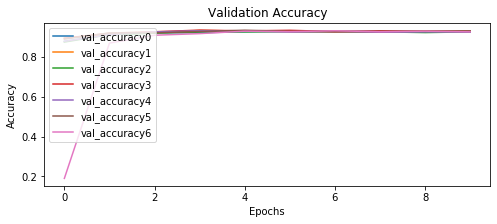

CNN 0: Epochs=10, Train Loss=0.02381, Validation Loss=0.25045
CNN 1: Epochs=10, Train Loss=0.00601, Validation Loss=0.24442
CNN 2: Epochs=10, Train Loss=0.01351, Validation Loss=0.24887
CNN 3: Epochs=10, Train Loss=0.00399, Validation Loss=0.23812
CNN 4: Epochs=10, Train Loss=0.00581, Validation Loss=0.24814
CNN 5: Epochs=10, Train Loss=0.00481, Validation Loss=0.24692
CNN 6: Epochs=10, Train Loss=0.02196, Validation Loss=0.24546


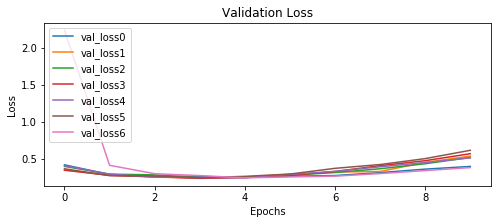

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 3 is the best one
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_209 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_213 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_214 (Conv2D)   

In [0]:
best = 3
#first layer weights
FLK = 32+8*best
#second layer weights
SLK = 64+16*best
#third layer weights
TLK = 48+8*best

### Validate the number neurons in the fully connected layer and a second fc layer

In [0]:
val_models = []

models_number = 6
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
    
    model.add(layers.Flatten())
    if i >= 3:
        model.add(layers.Dense(96+32*(i-3), activation='relu'))
        model.add(layers.Dense(64+32*(i-3), activation='relu'))
    else:
        model.add(layers.Dense(96+32*i, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [0]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/fully_connected/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 17s 253us/sample - loss: 0.9050 - accuracy: 0.7011 - val_loss: 0.3628 - val_accuracy: 0.8887
Epoch 2/10
65932/65932 [==============================] - 16s 247us/sample - loss: 0.2990 - accuracy: 0.9118 - val_loss: 0.3087 - val_accuracy: 0.9126
Epoch 3/10
65932/65932 [==============================] - 16s 248us/sample - loss: 0.2266 - accuracy: 0.9350 - val_loss: 0.2787 - val_accuracy: 0.9204
Epoch 4/10
65932/65932 [==============================] - 16s 247us/sample - loss: 0.1808 - accuracy: 0.9487 - val_loss: 0.2586 - val_accuracy: 0.9282
Epoch 5/10
65932/65932 [==============================] - 16s 245us/sample - loss: 0.1416 - accuracy: 0.9604 - val_loss: 0.2578 - val_accuracy: 0.9309
Epoch 6/10
65932/65932 [==============================] - 16s 245us/sample - loss: 0.1063 - accuracy: 0.9705 - val_loss: 0.2553 - val_accuracy: 0.9282
Epoch 7/10
65932/65932 [=====================

CNN 0: Epochs=10, Train Accuracy=0.99606, Validation Accuracy=0.93092
CNN 1: Epochs=10, Train Accuracy=0.99795, Validation Accuracy=0.93488
CNN 2: Epochs=10, Train Accuracy=0.99813, Validation Accuracy=0.93065
CNN 3: Epochs=10, Train Accuracy=0.99769, Validation Accuracy=0.93201
CNN 4: Epochs=10, Train Accuracy=0.99669, Validation Accuracy=0.93215
CNN 5: Epochs=10, Train Accuracy=0.99820, Validation Accuracy=0.93229


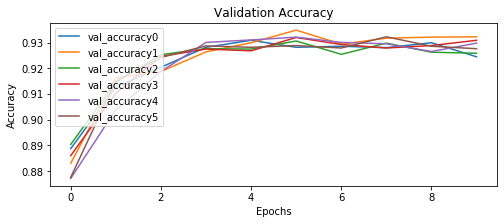

CNN 0: Epochs=10, Train Loss=0.01733, Validation Loss=0.25526
CNN 1: Epochs=10, Train Loss=0.00916, Validation Loss=0.25299
CNN 2: Epochs=10, Train Loss=0.00736, Validation Loss=0.25047
CNN 3: Epochs=10, Train Loss=0.01025, Validation Loss=0.25067
CNN 4: Epochs=10, Train Loss=0.01253, Validation Loss=0.23973
CNN 5: Epochs=10, Train Loss=0.00801, Validation Loss=0.25664


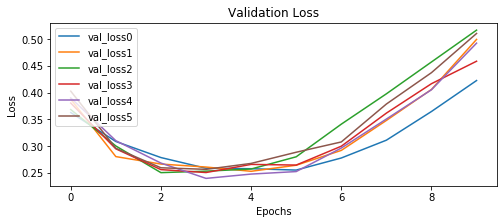

In [0]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [0]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_307 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_308 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_309 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_310 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_311 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_312 (Conv2D)   

In [0]:
best = 4
#fully connected layer weights
FDL = 96+32*(best-3)
SDL = 64+32*(best-3)

### Validate droput

In [0]:
val_models = []

DROPOUT = [round(x*0.05,2) for x in range(0,10)]

models_number = len(DROPOUT)
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(FDL, activation='relu'))
    model.add(layers.Dropout(DROPOUT[i]))
    model.add(layers.Dense(SDL, activation='relu'))
    model.add(layers.Dropout(DROPOUT[i]))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [61]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/dropout/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 17s 254us/sample - loss: 0.9368 - accuracy: 0.6876 - val_loss: 0.3867 - val_accuracy: 0.8853
Epoch 2/10
65932/65932 [==============================] - 16s 247us/sample - loss: 0.3092 - accuracy: 0.9079 - val_loss: 0.2928 - val_accuracy: 0.9136
Epoch 3/10
65932/65932 [==============================] - 16s 248us/sample - loss: 0.2325 - accuracy: 0.9322 - val_loss: 0.2623 - val_accuracy: 0.9222
Epoch 4/10
65932/65932 [==============================] - 16s 250us/sample - loss: 0.1833 - accuracy: 0.9480 - val_loss: 0.2420 - val_accuracy: 0.9312
Epoch 5/10
65932/65932 [==============================] - 17s 250us/sample - loss: 0.1448 - accuracy: 0.9594 - val_loss: 0.2560 - val_accuracy: 0.9252
Epoch 6/10
65932/65932 [==============================] - 17s 253us/sample - loss: 0.1110 - accuracy: 0.9701 - val_loss: 0.2563 - val_accuracy: 0.9282
Epoch 7/10
65932/65932 [=====================

CNN 0: Epochs=10, Train Accuracy=0.99434, Validation Accuracy=0.93119
CNN 1: Epochs=10, Train Accuracy=0.98764, Validation Accuracy=0.93392
CNN 2: Epochs=10, Train Accuracy=0.98356, Validation Accuracy=0.93420
CNN 3: Epochs=10, Train Accuracy=0.98007, Validation Accuracy=0.93870
CNN 4: Epochs=10, Train Accuracy=0.98429, Validation Accuracy=0.93406
CNN 5: Epochs=10, Train Accuracy=0.98006, Validation Accuracy=0.93461
CNN 6: Epochs=10, Train Accuracy=0.97440, Validation Accuracy=0.93611
CNN 7: Epochs=10, Train Accuracy=0.96857, Validation Accuracy=0.93488
CNN 8: Epochs=10, Train Accuracy=0.96691, Validation Accuracy=0.93652
CNN 9: Epochs=10, Train Accuracy=0.96207, Validation Accuracy=0.93693


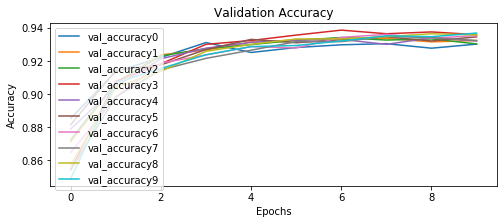

CNN 0: Epochs=10, Train Loss=0.02601, Validation Loss=0.24202
CNN 1: Epochs=10, Train Loss=0.04416, Validation Loss=0.23172
CNN 2: Epochs=10, Train Loss=0.05895, Validation Loss=0.24245
CNN 3: Epochs=10, Train Loss=0.07473, Validation Loss=0.24415
CNN 4: Epochs=10, Train Loss=0.05385, Validation Loss=0.24998
CNN 5: Epochs=10, Train Loss=0.07235, Validation Loss=0.24059
CNN 6: Epochs=10, Train Loss=0.08892, Validation Loss=0.23972
CNN 7: Epochs=10, Train Loss=0.11742, Validation Loss=0.24876
CNN 8: Epochs=10, Train Loss=0.12750, Validation Loss=0.24017
CNN 9: Epochs=10, Train Loss=0.14282, Validation Loss=0.24228


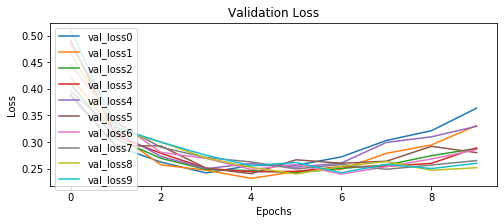

In [62]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [63]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 1 is the best one
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_567 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_568 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_569 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_570 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_571 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_572 (Conv2D)   

In [0]:
best = 1
BEST_DROPOUT = DROPOUT[best]

### Validate the batch size

In [0]:
val_models = []

batch_base = 24
batch_increment = 24

models_number = 10
for i in range(models_number):
    model = models.Sequential()
    
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
    
        
    model.add(layers.Flatten())
    model.add(layers.Dense(FDL, activation='relu'))
    model.add(layers.Dropout(BEST_DROPOUT))
    model.add(layers.Dense(SDL, activation='relu'))
    model.add(layers.Dropout(BEST_DROPOUT))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [89]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/batch/var'


for i in range(models_number):
    #adjusted batch size
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=batch_base + (i*batch_increment), epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i))))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 25s 380us/sample - loss: 0.8815 - accuracy: 0.7069 - val_loss: 0.3966 - val_accuracy: 0.8770
Epoch 2/10
65932/65932 [==============================] - 24s 370us/sample - loss: 0.3340 - accuracy: 0.9030 - val_loss: 0.2990 - val_accuracy: 0.9098
Epoch 3/10
65932/65932 [==============================] - 24s 369us/sample - loss: 0.2583 - accuracy: 0.9260 - val_loss: 0.2899 - val_accuracy: 0.9118
Epoch 4/10
65932/65932 [==============================] - 24s 366us/sample - loss: 0.2034 - accuracy: 0.9412 - val_loss: 0.2755 - val_accuracy: 0.9205
Epoch 5/10
65932/65932 [==============================] - 24s 369us/sample - loss: 0.1586 - accuracy: 0.9545 - val_loss: 0.2768 - val_accuracy: 0.9244
Epoch 6/10
65932/65932 [==============================] - 24s 368us/sample - loss: 0.1206 - accuracy: 0.9656 - val_loss: 0.2649 - val_accuracy: 0.9279
Epoch 7/10
65932/65932 [=====================

CNN 0: Epochs=10, Train Accuracy=0.99240, Validation Accuracy=0.92792
CNN 1: Epochs=10, Train Accuracy=0.99063, Validation Accuracy=0.93406
CNN 2: Epochs=10, Train Accuracy=0.99301, Validation Accuracy=0.93201
CNN 3: Epochs=10, Train Accuracy=0.99010, Validation Accuracy=0.93447
CNN 4: Epochs=10, Train Accuracy=0.99260, Validation Accuracy=0.93433
CNN 5: Epochs=10, Train Accuracy=0.98793, Validation Accuracy=0.93488
CNN 6: Epochs=10, Train Accuracy=0.98785, Validation Accuracy=0.93406
CNN 7: Epochs=10, Train Accuracy=0.98324, Validation Accuracy=0.93447
CNN 8: Epochs=10, Train Accuracy=0.97968, Validation Accuracy=0.93297
CNN 9: Epochs=10, Train Accuracy=0.98163, Validation Accuracy=0.93324


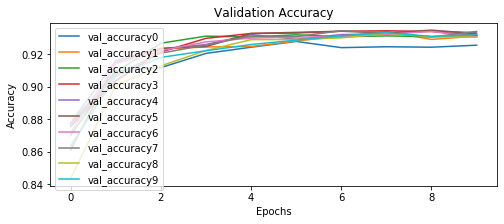

CNN 0: Epochs=10, Train Loss=0.02672, Validation Loss=0.26489
CNN 1: Epochs=10, Train Loss=0.03288, Validation Loss=0.25477
CNN 2: Epochs=10, Train Loss=0.02469, Validation Loss=0.23465
CNN 3: Epochs=10, Train Loss=0.03565, Validation Loss=0.23847
CNN 4: Epochs=10, Train Loss=0.02659, Validation Loss=0.23755
CNN 5: Epochs=10, Train Loss=0.04527, Validation Loss=0.22643
CNN 6: Epochs=10, Train Loss=0.04630, Validation Loss=0.24095
CNN 7: Epochs=10, Train Loss=0.06322, Validation Loss=0.23795
CNN 8: Epochs=10, Train Loss=0.07807, Validation Loss=0.24433
CNN 9: Epochs=10, Train Loss=0.06718, Validation Loss=0.25332


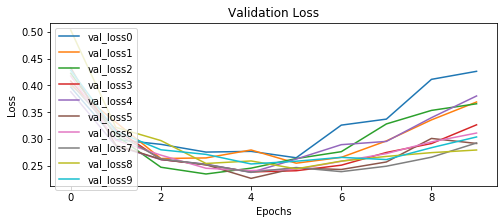

In [90]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [91]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 5 is the best one
Model: "sequential_161"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1043 (Conv2D)         (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_1044 (Conv2D)         (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_1045 (Conv2D)         (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_298 (MaxPoolin (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_1046 (Conv2D)         (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_1047 (Conv2D)         (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_1048 (Conv2D) 

In [0]:
best = 5
BEST_BATCH_SIZE = batch_base+(best*batch_increment)

### Validate Learning rate

In [0]:
val_models = []

models_number = 7
    
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
    
        
    model.add(layers.Flatten())
    model.add(layers.Dense(FDL, activation='relu'))
    model.add(layers.Dropout(BEST_DROPOUT))
    model.add(layers.Dense(SDL, activation='relu'))
    model.add(layers.Dropout(BEST_DROPOUT))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [26]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/learning_rate/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BEST_BATCH_SIZE, epochs=EPOCH_NUM+5,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i), lr=i)))

Train on 65932 samples, validate on 7325 samples
Epoch 1/15
65932/65932 [==============================] - 24s 367us/sample - loss: 1.0729 - accuracy: 0.6398 - val_loss: 0.4123 - val_accuracy: 0.8760
Epoch 2/15
65932/65932 [==============================] - 16s 238us/sample - loss: 0.3455 - accuracy: 0.8960 - val_loss: 0.3009 - val_accuracy: 0.9095
Epoch 3/15
65932/65932 [==============================] - 16s 240us/sample - loss: 0.2539 - accuracy: 0.9264 - val_loss: 0.2602 - val_accuracy: 0.9259
Epoch 4/15
65932/65932 [==============================] - 16s 242us/sample - loss: 0.2016 - accuracy: 0.9417 - val_loss: 0.2554 - val_accuracy: 0.9237
Epoch 5/15
65932/65932 [==============================] - 16s 243us/sample - loss: 0.1623 - accuracy: 0.9538 - val_loss: 0.2333 - val_accuracy: 0.9322
Epoch 6/15
65932/65932 [==============================] - 16s 245us/sample - loss: 0.1290 - accuracy: 0.9642 - val_loss: 0.2582 - val_accuracy: 0.9335
Epoch 7/15
65932/65932 [=====================

CNN 0: Epochs=15, Train Accuracy=0.99571, Validation Accuracy=0.93406
CNN 1: Epochs=15, Train Accuracy=0.99380, Validation Accuracy=0.93666
CNN 2: Epochs=15, Train Accuracy=0.99176, Validation Accuracy=0.92915
CNN 3: Epochs=15, Train Accuracy=0.98941, Validation Accuracy=0.93515
CNN 4: Epochs=15, Train Accuracy=0.98609, Validation Accuracy=0.93488
CNN 5: Epochs=15, Train Accuracy=0.97487, Validation Accuracy=0.93392
CNN 6: Epochs=15, Train Accuracy=0.97887, Validation Accuracy=0.93174


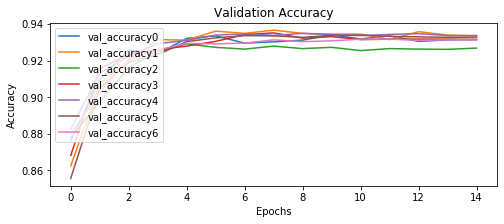

CNN 0: Epochs=15, Train Loss=0.01637, Validation Loss=0.23327
CNN 1: Epochs=15, Train Loss=0.02384, Validation Loss=0.23836
CNN 2: Epochs=15, Train Loss=0.03195, Validation Loss=0.24656
CNN 3: Epochs=15, Train Loss=0.04368, Validation Loss=0.23737
CNN 4: Epochs=15, Train Loss=0.05654, Validation Loss=0.22840
CNN 5: Epochs=15, Train Loss=0.09892, Validation Loss=0.23923
CNN 6: Epochs=15, Train Loss=0.08291, Validation Loss=0.24645


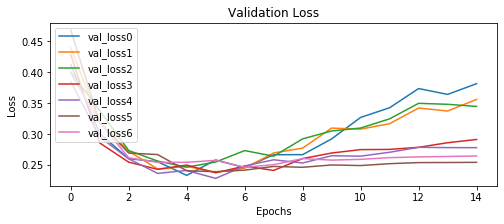

In [27]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [28]:
best = get_best_model(val_errors, loss=True)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 4 is the best one
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_168 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_169 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_170 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_171 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_172 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_173 (Conv2D)   

In [0]:
best = 4
BEST_LR = best

### Validate L2 regularization

In [0]:
val_models = []

reg_factor = [round(x*0.000025,5) for x in range(0,7)]

models_number = len(reg_factor)
for i in range(models_number):
    model = models.Sequential()
    
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1),
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu',
                            kernel_regularizer=regularizers.l2(reg_factor[i])))
        
    model.add(layers.Flatten())
    model.add(layers.Dense(FDL, activation='relu'))
    model.add(layers.Dropout(BEST_DROPOUT))
    model.add(layers.Dense(SDL, activation='relu'))
    model.add(layers.Dropout(BEST_DROPOUT))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    val_models.append(model)

In [28]:
#validate models
val_errors = []

#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/validation/l2_reg/var'


for i in range(models_number):
    val_errors.append(val_models[i].fit(train_img, train_lbs, batch_size=BEST_BATCH_SIZE, epochs=EPOCH_NUM,
                                        validation_data=(validation_img, validation_lbs), verbose = 1,
                                        callbacks=create_callbacks(base_name+str(i), lr=BEST_LR)))

Train on 65932 samples, validate on 7325 samples
Epoch 1/10
65932/65932 [==============================] - 26s 388us/sample - loss: 1.0587 - accuracy: 0.6420 - val_loss: 0.3862 - val_accuracy: 0.8818
Epoch 2/10
65932/65932 [==============================] - 18s 278us/sample - loss: 0.3259 - accuracy: 0.9037 - val_loss: 0.2976 - val_accuracy: 0.9111
Epoch 3/10
65932/65932 [==============================] - 18s 278us/sample - loss: 0.2399 - accuracy: 0.9309 - val_loss: 0.2594 - val_accuracy: 0.9249
Epoch 4/10
65932/65932 [==============================] - 18s 277us/sample - loss: 0.1895 - accuracy: 0.9471 - val_loss: 0.2396 - val_accuracy: 0.9327
Epoch 5/10
65932/65932 [==============================] - 18s 278us/sample - loss: 0.1556 - accuracy: 0.9564 - val_loss: 0.2319 - val_accuracy: 0.9341
Epoch 6/10
65932/65932 [==============================] - 18s 279us/sample - loss: 0.1266 - accuracy: 0.9654 - val_loss: 0.2419 - val_accuracy: 0.9356
Epoch 7/10
65932/65932 [=====================

CNN 0: Epochs=10, Train Accuracy=0.98206, Validation Accuracy=0.93570
CNN 1: Epochs=10, Train Accuracy=0.97143, Validation Accuracy=0.93433
CNN 2: Epochs=10, Train Accuracy=0.96980, Validation Accuracy=0.93379
CNN 3: Epochs=10, Train Accuracy=0.96085, Validation Accuracy=0.93174
CNN 4: Epochs=10, Train Accuracy=0.96462, Validation Accuracy=0.92860
CNN 5: Epochs=10, Train Accuracy=0.96386, Validation Accuracy=0.93311
CNN 6: Epochs=10, Train Accuracy=0.96446, Validation Accuracy=0.93338


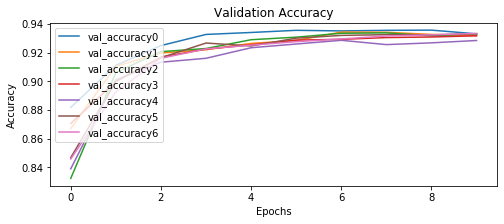

CNN 0: Epochs=10, Train Loss=0.07196, Validation Loss=0.23190
CNN 1: Epochs=10, Train Loss=0.12097, Validation Loss=0.24809
CNN 2: Epochs=10, Train Loss=0.13262, Validation Loss=0.26075
CNN 3: Epochs=10, Train Loss=0.16543, Validation Loss=0.26595
CNN 4: Epochs=10, Train Loss=0.15834, Validation Loss=0.27284
CNN 5: Epochs=10, Train Loss=0.16468, Validation Loss=0.27156
CNN 6: Epochs=10, Train Loss=0.16817, Validation Loss=0.27027


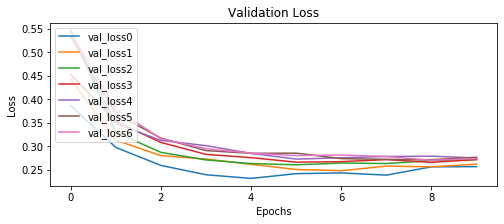

In [29]:
save_history(val_errors, base_name)

plot_validation(val_errors)

plot_validation(val_errors, loss=True)

In [30]:
#Rate base on accuracy because higher l2 regularization naturally inflates the loss
best = get_best_model(val_errors, loss=False)
print("Model number {0} is the best one".format(best))
val_models[best].summary()

Model number 0 is the best one
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 32, 32, 56)        560       
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 32, 32, 56)        28280     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 16, 16, 56)        0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 16, 16, 112)       56560     
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 16, 16, 112)       113008    
_________________________________________________________________
conv2d_145 (Conv2D)   

In [0]:
BEST_L2_REG = reg_factor[best]

### Train the model on the whole training set (train + validation renormalized)

In [0]:
#reload the datasets and renormalize them, without splitting the validation set.
train = loadmat('drive/My Drive/Colab Notebooks/train_32x32.mat')
test = loadmat('drive/My Drive/Colab Notebooks/test_32x32.mat')
train_img, train_lbs = train['X'], train['y']
test_img, test_lbs = test['X'], test['y']

train_img = np.transpose(train_img,[3,0,1,2])
test_img = np.transpose(test_img,[3,0,1,2])

train_lbs = np.where(train_lbs!=10, train_lbs, 0)
test_lbs = np.where(test_lbs!= 10, test_lbs, 0)

In [0]:
def rgb_to_gray(rgb):
    r,g,b = rgb[:,:,:,0], rgb[:,:,:,1], rgb[:,:,:,2]
    gray = 0.2989*r+0.5870*g+0.1140*b
    return gray.reshape(rgb.shape[0], rgb.shape[1], rgb.shape[2], 1)

train_img = rgb_to_gray(train_img)
test_img = rgb_to_gray(test_img)

In [0]:
train_mean = np.mean(train_img)
train_img = train_img - train_mean
train_std = np.std(train_img)
train_img = train_img / train_std

#do the same for the test set
test_img = test_img - train_mean
test_img = test_img / train_std

In [0]:
#create the final model
model = models.Sequential()
    
model = models.Sequential()
    
model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu', input_shape=(32,32,1)))
model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(FLK, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
model.add(layers.Conv2D(SLK, (3,3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D())
    
model.add(layers.Conv2D(TLK, (3,3), padding='same', activation='relu'))
        
model.add(layers.Flatten())
model.add(layers.Dense(FDL, activation='relu'))
model.add(layers.Dropout(BEST_DROPOUT))
model.add(layers.Dense(SDL, activation='relu'))
model.add(layers.Dropout(BEST_DROPOUT))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
#create the directory where to save the checkpoints (otherwise throws a nosuch file exception)
base_name = './gray/training/model'
os.makedirs(base_name, exist_ok=True)

#train it
history = model.fit(train_img, train_lbs, batch_size=BEST_BATCH_SIZE, epochs=EPOCH_NUM*2,
                    validation_data=(test_img, test_lbs),
                    verbose = 1, callbacks=create_callbacks(base_name+str(i), lr=BEST_LR))

Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 22s 307us/sample - loss: 0.5148 - accuracy: 0.8411 - val_loss: 0.3641 - val_accuracy: 0.8913
Epoch 2/20
73257/73257 [==============================] - 22s 299us/sample - loss: 0.2882 - accuracy: 0.9148 - val_loss: 0.2784 - val_accuracy: 0.9204
Epoch 3/20
73257/73257 [==============================] - 22s 301us/sample - loss: 0.2200 - accuracy: 0.9368 - val_loss: 0.2438 - val_accuracy: 0.9296
Epoch 4/20
73257/73257 [==============================] - 22s 300us/sample - loss: 0.1757 - accuracy: 0.9505 - val_loss: 0.2191 - val_accuracy: 0.9380
Epoch 5/20
73257/73257 [==============================] - 22s 302us/sample - loss: 0.1430 - accuracy: 0.9607 - val_loss: 0.2087 - val_accuracy: 0.9417
Epoch 6/20
73257/73257 [==============================] - 22s 301us/sample - loss: 0.1154 - accuracy: 0.9693 - val_loss: 0.2105 - val_accuracy: 0.9411
Epoch 7/20
73257/73257 [====================

CNN 0: Epochs=20, Train Accuracy=0.98976, Validation Accuracy=0.94269


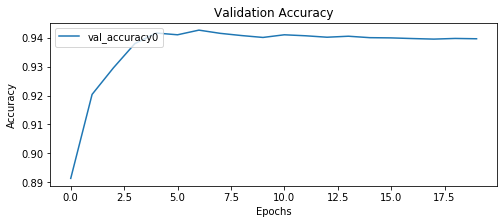

CNN 0: Epochs=20, Train Loss=0.04369, Validation Loss=0.20867


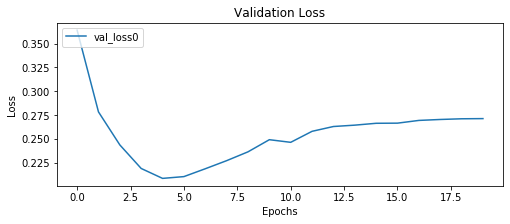

In [38]:
save_history([history], base_name)

plot_validation([history])

plot_validation([history], loss=True)

In [39]:
model.evaluate(test_img, test_lbs)

26032/26032 [==============================] - 4s 158us/sample - loss: 0.2713 - accuracy: 0.9397


[0.27134274702932965, 0.93968964]